# Predicció de Preferències en Respostes de Models de Llenguatge

**Autors:** Iker Bolacel | Arun Sharma
**Titulació:** Enginyeria Informàtica  
**Assignatura:** Aprenentatge Computacional  
**Data:** Desembre 2025

---

# Contingut

1. **EDA (Exploratory Data Analysis)** 

* Data Types Analysis

* target Analysis

* Missing Values Check

* Target Distribution

* Models Used in Dataset

* Prompt Analysis

* Duplicate Prompts Examples

* Response Length Analysis

* Models winrate

2. **Preprocessing for Logistic regression and LightGBM** 

* Feature Engineering and Validation

* Check feature distributions

* Feature correlation with target

* Train/Test split preserving prompt groups

* Verify TF-IDF preprocessing

* Build and validate feature matrix

3. **Metric selection**

4. **Logistic Regression training and evaluation**

5. **LightGBM training and evaluation**

6. **Preprocessing for LightGBM + embeddings**

7. **LightGBM + embeddings training and evaluation**

8. **Preprocessing for deBERTa**

9.  **deBERTa training and evaluation**

10. **Anàlisi final** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from itertools import product
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import re

df = pd.read_csv('train.csv')
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


# 1. EDA (Exploratory Data Analysis)

## Data Types Analysis

In [2]:
tipus = {
    'numerics': [],
    'categorics': [],
    'binars': [],
    'temporals': [],
    'altres': []
  }
def tipus_atributs(df):

    for col in df.columns:
        tipus_col = df[col].dtype

        if pd.api.types.is_datetime64_any_dtype(df[col]):
            tipus['temporals'].append(col)

        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                tipus['binars'].append(col)
            else:
                tipus['numerics'].append(col)

        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            if df[col].nunique() == 2:
                tipus['binars'].append(col)
            else:
                tipus['categorics'].append(col)
        else:
            tipus['altres'].append(col)

    return tipus


print (tipus_atributs(df))

{'numerics': ['id'], 'categorics': ['model_a', 'model_b', 'prompt', 'response_a', 'response_b'], 'binars': ['winner_model_a', 'winner_model_b', 'winner_tie'], 'temporals': [], 'altres': []}


Tot i que la detecció automàtica de tipus classifica la majoria de variables com a categòriques, cal fer una distinció fonamental en la naturalesa d'aquestes dades. Les columnes prompt, response_a i response_b no són simples categories, sinó que contenen text lliure que necessita ser interpretat semànticament mitjançant tècniques de Processament de Llenguatge Natural com la tokenització, els embeddings o el TF-IDF. En canvi, les variables model_a i model_b sí que funcionen com a veritables categories, ja que identifiquen de manera discreta quin model generador ha produït cada resposta. Pel que fa a la variable objectiu, aquesta es troba representada de forma binària a través de tres columnes mútuament excloents: winner_model_a, winner_model_b i winner_tie, on només una pot tenir valor 1 per a cada mostra.

## Target Variable Structure

In [3]:
def target(df):
    return {"winner_model_a":df['winner_model_a'].unique(),"winner_model_b":df['winner_model_b'].unique(),"winner_tie":df['winner_tie'].unique(),}

print (target(df))

{'winner_model_a': array([1, 0]), 'winner_model_b': array([0, 1]), 'winner_tie': array([0, 1])}


## Missing Values Check

In [4]:
def valors_nuls(df):

    return df.isnull().sum()

print (valors_nuls(df))

id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64


En analitzar els valors nuls del conjunt de dades, observem que no hi ha cap valor absent (NaN) en cap de les columnes. Aquesta circumstància simplifica considerablement el preprocessament, ja que ens estalvia la necessitat d'aplicar tècniques d'imputació o eliminació de registres incomplets, permetent-nos treballar amb la totalitat de les mostres disponibles sense preocupacions sobre la integritat de les dades.

## Target Distribution

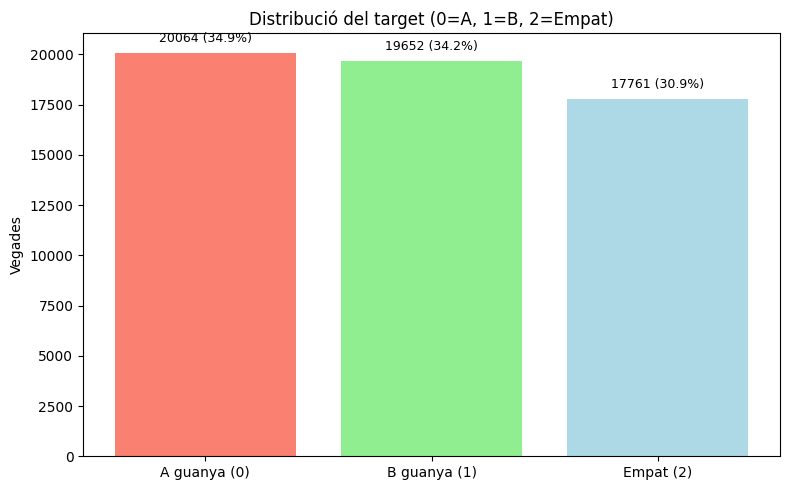

In [5]:
def get_outcome(row):
    a = int(row.get('winner_model_a', 0))
    b = int(row.get('winner_model_b', 0))
    t = int(row.get('winner_tie', 0))
    if a == 1:
        return 0
    if b == 1:
        return 1
    return 2

df['target_unio'] = df.apply(get_outcome, axis=1)
counts = df['target_unio'].value_counts(dropna=False).sort_index()

pct = 100 * counts / counts.sum()

labels = ['A guanya (0)', 'B guanya (1)', 'Empat (2)']


counts_list = [counts.get(i, 0) for i in [0,1,2]]
pct_list = [pct.get(i, 0) for i in [0,1,2]]


fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(labels, counts_list, color=['salmon', 'lightgreen', 'lightblue'])


max_count = max(counts_list) if len(counts_list) > 0 else 1
for bar, c, p in zip(bars, counts_list, pct_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + max_count*0.02,
            f"{c} ({p:.1f}%)",
            ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Vegades')
ax.set_title('Distribució del target (0=A, 1=B, 2=Empat)')
plt.tight_layout()
plt.show()

En examinar la distribució de la variable objectiu, podem concloure que el conjunt de dades presenta un equilibri acceptable entre les tres classes. Considerant que una distribució perfectament balancejada seria del 33,3% per a cada categoria, la desviació màxima que observem és de només un 2,4% en la classe d'empat. Aquest nivell de desbalanceig és prou modest com per no requerir tècniques especials de tractament, cosa que ens permet entrenar els models sense haver d'aplicar estratègies com el re-mostreig, l'ajust de pesos de classe o la generació sintètica de dades.

## Models Used in Dataset

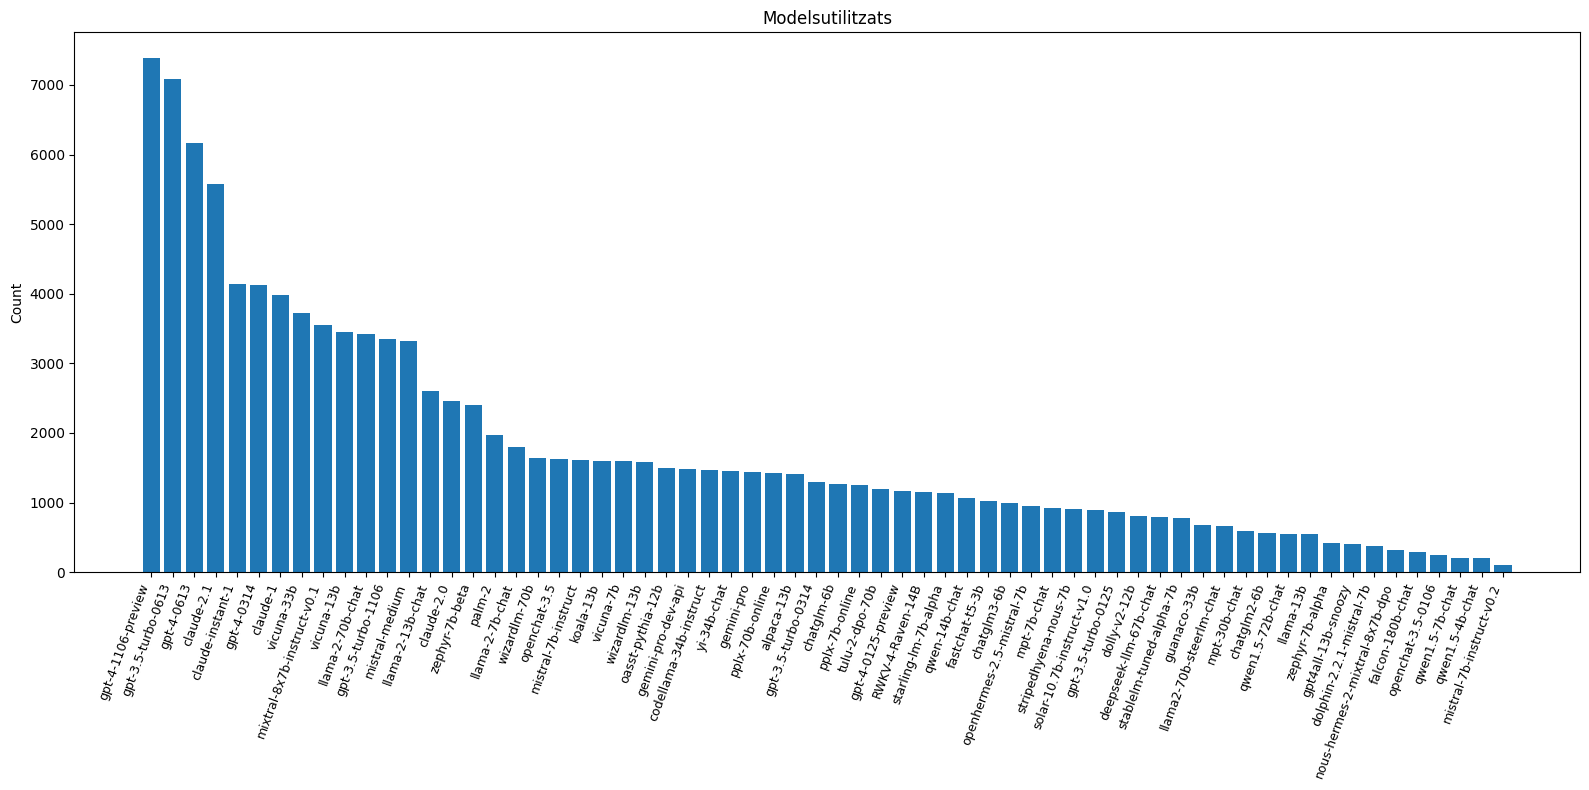

In [6]:
models=pd.concat([df.model_a, df.model_b])
counts = models.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

plt.figure(figsize=(16,8))
plt.bar(counts['LLM'], counts['Count'])
plt.xticks(rotation=70, fontsize=9, ha='right')
plt.ylabel("Count")
plt.title("Modelsutilitzats")
plt.tight_layout()
plt.show()

En analitzar la distribució dels models generadors presents al conjunt de dades, descobrim un ecosistema força heterogeni que reflecteix la diversitat actual del panorama dels models de llenguatge. Tot i que les variants de la família GPT d'OpenAI mantenen una presència destacada, el dataset incorpora una representació àmplia d'altres arquitectures i desenvolupadors, incloent models com Claude d'Anthropic, Gemini de Google, així com alternatives de codi obert com Llama, Vicuna i Mistral.

## Prompt Analysis

In [7]:
print("Prompts duplicats:", df['prompt'].duplicated().sum())

duplicats = df['prompt'].value_counts()
print("prompts duplicats:")
print(duplicats[duplicats > 1].head(10))

print("Prompts únics:", df['prompt'].nunique())

percent_unics = (df['prompt'].nunique() / len(df['prompt'])) * 100
print("Percentatge de prompts únics:", percent_unics, "%")

Prompts duplicats: 5743
prompts duplicats:
prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that

En examinar la unicitat dels prompts, hem identificat l'existència de 5743 prompts duplicats dins del conjunt de dades. Aquest fet mereix una atenció especial, ja que la presència dels mateixos prompts tant en el conjunt d'entrenament com en el de validació podria provocar un fenomen de data leakage que inflaria artificialment les mètriques de rendiment, donant una falsa impressió de generalització. Per tant, serà crucial implementar una estratègia de partició que garanteixi que cada prompt únic aparegui exclusivament en un dels dos conjunts. Pel que fa a la naturalesa d'aquests duplicats, trobem un patró interessant: mentre que el prompt més repetit correspon a una instrucció complexa sobre un qüestionari d'acord/desacord, la gran majoria dels duplicats són salutacions genèriques com "hey" o "hello", així com preguntes molt simples com "test" o "tell me a joke".

## Duplicate Prompts Examples

In [8]:
dup = '["tell me a joke"]'
prompt_ex =  df[df['prompt'] == dup]
prompt_ex


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,target_unio
426,32362908,gpt-3.5-turbo-0613,solar-10.7b-instruct-v1.0,"[""tell me a joke""]","[""Sure, here's a classic one for you: Why don'...","[""Here's a classic joke for you:\n\nWhy don't ...",0,0,1,2
3064,234475192,claude-instant-1,tulu-2-dpo-70b,"[""tell me a joke""]","[""Here's one: Why can't a bicycle stand on its...","[""Sure, here's a joke for you:\n\nWhy was the ...",0,0,1,2
4482,338888055,gpt-4-1106-preview,gpt-3.5-turbo-1106,"[""tell me a joke""]","[""Why don't skeletons fight each other?\n\nThe...","[""Sure, here's a joke for you:\n\nWhy don't sk...",0,0,1,2
9155,684183825,zephyr-7b-beta,llama-2-13b-chat,"[""tell me a joke""]","[""Why did the scarecrow get a promotion?\n\nBe...","[""Sure, here's a joke for you:\n\nWhy couldn't...",1,0,0,0
9739,723359570,claude-2.1,gpt-4-1106-preview,"[""tell me a joke""]","[""Why can't a bicycle stand up by itself? Beca...","[""Why don't skeletons fight each other? They d...",0,0,1,2
11552,854733088,gpt-3.5-turbo-1106,gpt-4-0613,"[""tell me a joke""]","[""Sure, here's a joke for you:\n\nWhy did the ...","[""Sure, here's a classic one for you: \n\nWhy ...",0,1,0,1
12522,928471905,tulu-2-dpo-70b,mistral-medium,"[""tell me a joke""]","[""Sure, here's a classic joke:\n\nWhy was the ...","[""Sure, here's a joke for you:\n\nWhy couldn't...",0,0,1,2
12857,953971030,starling-lm-7b-alpha,llama-2-70b-chat,"[""tell me a joke""]","[""Why don't scientists trust atoms? Because th...","[""Sure, here's a joke for you:\n\nWhy couldn't...",0,1,0,1
14954,1115463106,gpt-4-1106-preview,gpt-4-0613,"[""tell me a joke""]","[""Sure! Here's a light-hearted joke for you:\n...","[""Sure, here's one for you: \n\nWhy don't scie...",1,0,0,0
15226,1135796725,stripedhyena-nous-7b,starling-lm-7b-alpha,"[""tell me a joke""]","[""Why did the tomato turn red? Because it saw ...","[""Why don't scientists trust atoms? Because th...",1,0,0,0


## Response Length Analysis

In [9]:
df_copy = df.copy()
df_copy["len_a"]=df_copy["response_a"].str.len()
df_copy["len_b"]=df_copy["response_b"].str.len()
df_copy[["len_a","len_b"]].describe()

,len_a,len_b
count,57477.000000,57477.000000
mean,1377.818919,1386.162169
std,1513.932333,1537.800488
min,4.000000,4.000000
25%,408.000000,413.000000
50%,1076.000000,1086.000000
75%,1862.000000,1873.000000
max,54058.000000,53830.000000


El len mitjà de les respostes a i b en molt similars, pero podem veure també com la variança es molt alta, per tant poden haver-hi diferencies molt grans en la mida de les respostes. També podem observar com la mediana es més petita que la mitjana, cosa que indica que hi ha respostes extremadament llargues com podem observar també a max, que trobem que hi han un parell de respostes amb 54058 i 53830 caracters.

Aquesta distribució de longituds presenta un repte per als models tipus Transformer. Considerant que l'entrada del model concatena el Prompt amb les dues respostes, la longitud mitjana total (~3.100 caràcters) es tradueix en aproximadament 900-1000 tokens. Hem de vigilar especialment la quantitat de tokens ja que models com deBERTa procesen 512 tokens de forma predeterminada, això implica que en més del 50% dels casos, el model patirà truncament sever. Això pot provocar que part de la segona resposta quedi fora de l'anàlisi, forçant al model a prendre decisions amb informació incompleta i explicant potencials mancances en el rendiment.

## Models winrate

In [10]:
wins_a = df[df['target_unio']==0].groupby('model_a').size()
wins_b = df[df['target_unio']==1].groupby('model_b').size()
wins = wins_a.add(wins_b, fill_value=0)
appearances = df['model_a'].value_counts().add(df['model_b'].value_counts(), fill_value=0)
summary = pd.DataFrame({
    'wins': wins,
    'appearances': appearances
}).fillna(0)

summary['wins'] = summary['wins'].astype(int)
summary['appearances'] = summary['appearances'].astype(int)

summary['winrate'] = summary['wins'] / summary['appearances']

summary_sorted = summary.sort_values('winrate', ascending=False)
display(summary_sorted.head(20))

,wins,appearances,winrate
gpt-4-1106-preview,4073,7387,0.551374
gpt-3.5-turbo-0314,711,1302,0.546083
gpt-4-0125-preview,596,1160,0.513793
gpt-4-0314,1993,4122,0.483503
claude-1,1747,3978,0.439165
gpt-4-0613,2450,6165,0.397405
claude-instant-1,1642,4136,0.397002
qwen1.5-72b-chat,215,551,0.390200
claude-2.0,956,2456,0.389251
llama-2-70b-chat,1277,3428,0.372520


En analitzar les taxes de victòria (winrates) dels diferents models generadors, observem que les variants de ChatGPT encapçalen el rànquing amb els percentatges més elevats d'èxit en les comparacions directes. Aquesta supremacia és seguida de prop per altres models destacats com Claude.

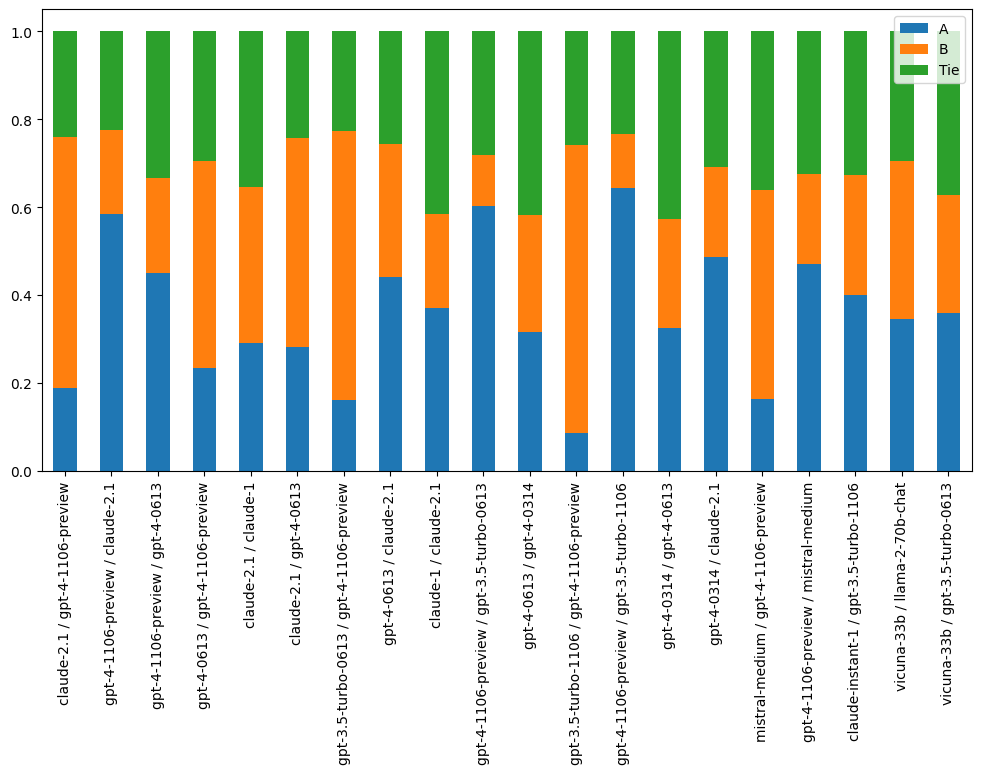

In [11]:
ct = pd.crosstab(df['model_a'] + " / " + df['model_b'], df['target_unio'])
ct_norm = ct.div(ct.sum(axis=1), axis=0)
top_pairs = df['model_a'].astype(str) + " / " + df['model_b'].astype(str)
top_pairs = top_pairs.value_counts().head(20).index
ct_norm.loc[top_pairs].plot(kind='bar', stacked=True, figsize=(12,6))
plt.legend(['A','B','Tie'])
plt.show()

# 2. Preprocessing for Logistic regression and LightGBM

## Feature Engineering and Validation

In [12]:
# Enhanced Feature Engineering
import warnings
warnings.filterwarnings('ignore')

# Create a fresh copy
df_enhanced = df.copy()

# 1. MODEL FEATURES
# Calculate historical win rates for each model
# model_stats = {}
# for model_col in ['model_a', 'model_b']:
#     for model in df[model_col].unique():
#         if model not in model_stats:
#             # Count wins when this model is A
#             mask_a = (df['model_a'] == model)
#             wins_as_a = df[mask_a]['winner_model_a'].sum()
#             total_as_a = mask_a.sum()
            
#             # Count wins when this model is B
#             mask_b = (df['model_b'] == model)
#             wins_as_b = df[mask_b]['winner_model_b'].sum()
#             total_as_b = mask_b.sum()
            
#             # Overall win rate
#             total_wins = wins_as_a + wins_as_b
#             total_appearances = total_as_a + total_as_b
#             win_rate = total_wins / total_appearances if total_appearances > 0 else 0.33
            
#             model_stats[model] = win_rate

# # Add model quality features
# df_enhanced['model_a_winrate'] = df_enhanced['model_a'].map(model_stats)
# df_enhanced['model_b_winrate'] = df_enhanced['model_b'].map(model_stats)
# df_enhanced['winrate_diff'] = df_enhanced['model_a_winrate'] - df_enhanced['model_b_winrate']

# 2. LENGTH COMPARISON FEATURES
df_enhanced['len_prompt'] = df_enhanced['prompt'].str.len()
df_enhanced['len_a'] = df_enhanced['response_a'].str.len()
df_enhanced['len_b'] = df_enhanced['response_b'].str.len()
df_enhanced['len_diff'] = df_enhanced['len_a'] - df_enhanced['len_b']
df_enhanced['len_ratio'] = df_enhanced['len_a'] / (df_enhanced['len_b'] + 1)

# 3. TEXT QUALITY FEATURES
def count_sentences(text):
    if pd.isna(text): return 0
    return len(re.findall(r'[.!?]+', str(text)))

def count_code_blocks(text):
    if pd.isna(text): return 0
    return len(re.findall(r'```', str(text)))



df_enhanced['sentences_a'] = df_enhanced['response_a'].apply(count_sentences)
df_enhanced['sentences_b'] = df_enhanced['response_b'].apply(count_sentences)
df_enhanced['code_blocks_a'] = df_enhanced['response_a'].apply(count_code_blocks)
df_enhanced['code_blocks_b'] = df_enhanced['response_b'].apply(count_code_blocks)


df_enhanced['sentences_diff'] = df_enhanced['sentences_a'] - df_enhanced['sentences_b']
df_enhanced['code_blocks_diff'] = df_enhanced['code_blocks_a'] - df_enhanced['code_blocks_b']


# 4. PROMPT FEATURES
df_enhanced['prompt_num_questions'] = df_enhanced['prompt'].apply(lambda x: str(x).count('?'))
df_enhanced['prompt_num_msgs'] = df_enhanced['prompt'].apply(lambda x: str(x).count('","'))

# 5. JACCARD SIMILARITY
def jaccard(a, b):
    A = set(str(a).lower().split())
    B = set(str(b).lower().split())
    if not A and not B: return 0.0
    return len(A & B) / len(A | B)

df_enhanced['jaccard_ab'] = df_enhanced.apply(
    lambda r: jaccard(r['response_a'], r['response_b']), axis=1
)

print("Enhanced features created")
print(f"Total features: {len(df_enhanced.columns)}")
new_cols = [c for c in df_enhanced.columns if c not in df.columns]
print(f"New features: {len(new_cols)}")

Enhanced features created
Total features: 24
New features: 14


Realitzem feature engineering per extreure mètriques numèriques del text que ajudin el model a comparar les respostes A i B. Creem variables que mesuren la longitud (diferència de caràcters), l'estructura (compteig d'oracions, blocs de codi) i similitud entre respostes (Jaccard).

No utilitzarem els winrates agregats per model com a característica d’entrenament. Observant les correlacions que teniem, aquestes features feien que el model doni més pes a l’identitat del generador que a la semàntica i qualitat real de la resposta, cosa que empitjora la generalització. Això crea un judge over-fitting: el predictor aprèn la reputació del model en lloc d’aprendre a valorar el text. Si en el futur s’afegeixen models no vists durant l’entrenament, és molt probable que el sistema segueixi afavorint els models ja coneguts, encara que apareguin nous generadors amb respostes excel·lents. Per tant, l’entrada del model hauria de basar-se exclusivament en el prompt i les respostes (A vs B) i en característiques derivades del text

### Check feature distributions

In [13]:

numerical_features = [
    #'model_a_winrate', 'model_b_winrate', 'winrate_diff',
    'len_prompt', 'len_a', 'len_b', 'len_diff', 'len_ratio',
    'sentences_a', 'sentences_b', 'sentences_diff',
    'code_blocks_a', 'code_blocks_b', 'code_blocks_diff',
    'prompt_num_questions', 'prompt_num_msgs',
    'jaccard_ab'
]

print("\nBasic statistics:")
print(df_enhanced[numerical_features].describe())


Basic statistics:
         len_prompt         len_a         len_b      len_diff     len_ratio  \
count  57477.000000  57477.000000  57477.000000  57477.000000  57477.000000   
mean     369.198584   1377.818919   1386.162169     -8.343250      1.953986   
std     1073.341472   1513.932333   1537.800488   1098.046783      8.518360   
min        7.000000      4.000000      4.000000 -52573.000000      0.001496   
25%       52.000000    408.000000    413.000000   -427.000000      0.625885   
50%       96.000000   1076.000000   1086.000000      0.000000      0.995614   
75%      243.000000   1862.000000   1873.000000    416.000000      1.575560   
max    33056.000000  54058.000000  53830.000000  43542.000000    973.200000   

        sentences_a   sentences_b  sentences_diff  code_blocks_a  \
count  57477.000000  57477.000000    57477.000000   57477.000000   
mean      14.124328     14.236112       -0.111784       0.404805   
std       16.545876     17.079502       13.588767       2.786516 

L'anàlisi descriptiva de les característiques numèriques generades destaca diversos aspectes rellevants. Primerament, els valors extrems en longitud i el ràtio entre respostes confirmen novament la presència de respostes considerablement extenses que ja havíem identificat anteriorment. Un altre patró interessant és l'escassetat de blocs de codi, amb una mediana de zero, la qual cosa indica que la majoria de les tasques plantejades als models són de naturalesa textual pura, sense requerir exemples de programació. Finalment, l'índex de similitud de Jaccard presenta valors generalment baixos, amb una mediana de 0.18, fet que confirma que els diferents models generadors tendeixen a produir respostes lèxicament molt diferents entre si, encara que ocasionalment poden coincidir en contingut o formulació.

### Feature correlation with target

In [14]:
df_enhanced['target'] = df_enhanced.apply(
    lambda r: 0 if r['winner_model_a'] == 1 else (1 if r['winner_model_b'] == 1 else 2),
    axis=1
)

for target_class in [0, 1, 2]:
    binary_target = (df_enhanced['target'] == target_class).astype(int)
    correlations = df_enhanced[numerical_features].corrwith(binary_target).abs().sort_values(ascending=False)
    
    class_name = ['Model A wins', 'Model B wins', 'Tie'][target_class]
    print(f"\nTop 5 features correlated with {class_name}:")
    print(correlations.head(5))


Top 5 features correlated with Model A wins:
len_diff          0.174625
sentences_diff    0.153120
len_a             0.091810
sentences_a       0.088662
jaccard_ab        0.065118
dtype: float64

Top 5 features correlated with Model B wins:
len_diff          0.176913
sentences_diff    0.149233
len_b             0.085754
sentences_b       0.076443
jaccard_ab        0.072015
dtype: float64

Top 5 features correlated with Tie:
jaccard_ab     0.141100
len_b          0.052643
len_a          0.052408
sentences_a    0.046650
sentences_b    0.041404
dtype: float64


Observem que la victòria del model A o B està estretament lligada a la diferència de longitud de la resposta (len_diff). Això confirma que, en la majoria de casos, existeix un biaix cap a les respostes més llargues. Pel que fa a l'empat, veiem que la característica més determinant és l'índex de Jaccard. Això ens indica que quan les respostes són lèxicament molt similars, la probabilitat que es determini un empat augmenta significativament.

### Train/Test split preserving prompt groups

In [16]:
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r'^\s*\[[\"\']', '', s)
    s = re.sub(r'[\"\']?\]\s*$', '', s)
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()
    return s

for col in ['prompt', 'response_a', 'response_b']:
    df_enhanced[col + '_clean'] = df_enhanced[col].apply(clean_text)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df_enhanced['prompt']
train_idx, test_idx = next(gss.split(df_enhanced, groups=groups))

train_df = df_enhanced.iloc[train_idx].reset_index(drop=True)
test_df = df_enhanced.iloc[test_idx].reset_index(drop=True)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTarget distribution (train):")
print(train_df['target'].value_counts(normalize=True).sort_index())
print(f"\nTarget distribution (test):")
print(test_df['target'].value_counts(normalize=True).sort_index())

train_prompts = set(train_df['prompt'])
test_prompts = set(test_df['prompt'])
overlap = train_prompts.intersection(test_prompts)
print(f"\nPrompt leakage check: {len(overlap)} overlapping prompts (should be 0)")

Train size: 45934
Test size: 11543

Target distribution (train):
target
0    0.347433
1    0.342796
2    0.309771
Name: proportion, dtype: float64

Target distribution (test):
target
0    0.355627
1    0.338387
2    0.305986
Name: proportion, dtype: float64

Prompt leakage check: 0 overlapping prompts (should be 0)


Com ja havíem mencionat anteriorment, la repetició d’un mateix prompt tant en el conjunt d’entrenament com en el de test pot provocar un problema greu de data leakage. En aquest escenari, el model podria aprendre patrons específics del prompt durant l’entrenament i després reutilitzar-los en la fase d’avaluació, produint mètriques artificialment inflades que no reflecteixen la seva capacitat real de generalització.

Per prevenir aquesta circumstància, hem implementat una estratègia de partició basada en GroupShuffleSplit, un mètode especialitzat que garanteix que totes les mostres vinculades a un mateix grup identificador, en aquest cas el prompt, apareguin exclusivament en un dels dos subconjunts: entrenament o validació, però mai simultàniament en ambdós. D'aquesta manera, quan el model s'avaluï amb el conjunt de test, enfrontarà prompts que mai ha vist durant l'entrenament, proporcionant així una estimació honest i realista de la seva capacitat de generalització.

### Verify TF-IDF preprocessing

In [17]:
sample_idx = 0
print("Original prompt:")
print(train_df.iloc[sample_idx]['prompt'][:200])
print("\nCleaned prompt:")
print(train_df.iloc[sample_idx]['prompt_clean'][:200])

print("\n" + "="*50)
print("Original response A:")
print(train_df.iloc[sample_idx]['response_a'][:200])
print("\nCleaned response A:")
print(train_df.iloc[sample_idx]['response_a_clean'][:200])

Original prompt:
["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

Cleaned prompt:
is it morally right to try to have a certain percentage of females on managerial positions?","ok, does pineapple belong on a pizza? relax and give me fun answer.

Original response A:
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversit

Cleaned response A:
the question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity,


### Build and validate feature matrix

In [18]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numerical_features])
X_test_num = scaler.transform(test_df[numerical_features])

print("Numerical features shape:")
print(f"Train: {X_train_num.shape}")
print(f"Test: {X_test_num.shape}")

print("\nNumerical features after scaling (first 5):")
print("Mean (should be ~0):", X_train_num.mean(axis=0)[:5])
print("Std (should be ~1):", X_train_num.std(axis=0)[:5])

train_corpus = []
for _, row in train_df.iterrows():
    doc = f"{row['prompt_clean']} [RESPONSE_A] {row['response_a_clean']} [RESPONSE_B] {row['response_b_clean']}"
    train_corpus.append(doc)

test_corpus = []
for _, row in test_df.iterrows():
    doc = f"{row['prompt_clean']} [RESPONSE_A] {row['response_a_clean']} [RESPONSE_B] {row['response_b_clean']}"
    test_corpus.append(doc)

vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_text = vec.fit_transform(train_corpus)
X_test_text = vec.transform(test_corpus)

print("\nTF-IDF features shape:")
print(f"Train: {X_train_text.shape}")
print(f"Test: {X_test_text.shape}")
print(f"Vocabulary size: {len(vec.vocabulary_)}")

# Combine features
X_train_combined = hstack([X_train_text, csr_matrix(X_train_num)]).tocsr()
X_test_combined = hstack([X_test_text, csr_matrix(X_test_num)]).tocsr()

y_train = train_df['target'].values
y_test = test_df['target'].values

print("\nFinal feature matrix:")
print(f"Train: {X_train_combined.shape}")
print(f"Test: {X_test_combined.shape}")
print(f"Sparsity: {1 - X_train_combined.nnz / (X_train_combined.shape[0] * X_train_combined.shape[1]):.4f}")

Numerical features shape:
Train: (45934, 14)
Test: (11543, 14)

Numerical features after scaling (first 5):
Mean (should be ~0): [-2.04187837e-17 -6.00188491e-17  4.14563185e-17  1.14468939e-17
  3.09375511e-18]
Std (should be ~1): [1. 1. 1. 1. 1.]

TF-IDF features shape:
Train: (45934, 5000)
Test: (11543, 5000)
Vocabulary size: 5000

Final feature matrix:
Train: (45934, 5014)
Test: (11543, 5014)
Sparsity: 0.9602


El procés de construcció de la matriu final de característiques consta de diverses etapes fonamentals. Primerament, apliquem StandardScaler a les nostres característiques engineered per normalitzar els rangs de valors, evitant així que variables amb magnituds naturalment grans, com ara la longitud de caràcters, dominin injustament el procés d'aprenentatge del model en detriment de característiques igualment informatives però amb valors més petits.

A continuació, transformem el text concatenat (que inclou el prompt original seguit de la resposta A i la resposta B) en vectors numèrics mitjançant la tècnica TF-IDF. Aquesta representació pondera cada paraula segons la seva freqüència al document actual relativament a la seva freqüència global al corpus, permetent identificar termes distintius. Per mantenir la dimensionalitat manejable, limitem la representació a les 5.000 característiques més rellevants i configurem el vectoritzador per capturar no només paraules individuals sinó també bi-grams (ngram_range=(1,2)), la qual cosa ens permet retenir cert context sintàctic i expressions compostes.

Finalment, utilitzem la funció hstack per combinar horitzontalment les dades textuals processades amb TF-IDF i les característiques numèriques escalades, creant així una matriu d'entrenament unificada que conté tota la informació disponible tant dels aspectes semàntics del text com de les propietats estructurals i estadístiques que hem extret prèviament.

# 3. Metric selection

Hem seleccionat el Log Loss com a mètrica principal d'avaluació perquè el nostre objectiu transcendeix la simple classificació correcta de les mostres. El que realment busquem és obtenir probabilitats ben calibrades que reflecteixin la confiança real del model en les seves prediccions. El Log Loss penalitza severament aquelles prediccions incorrectes realitzades amb alta confiança, forçant així el model a ser honest sobre la seva incertesa. Això ens proporciona una visió molt més realista i matisada del rendiment real del sistema, ja que no només importa encertar el guanyador, sinó també expressar adequadament el grau de certesa d'aquesta decisió.

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

Per complementar aquesta anàlisi quantitativa, utilitzarem també les corbes ROC juntament amb l'àrea sota la corba (AUC). Aquestes eines visuals ens permeten avaluar la capacitat discriminativa real del model a través de tots els possibles llindars de decisió. Una corba ROC elevada indica que el model posseeix una habilitat genuïna per separar clarament les diferents classes, identificant amb èxit quan guanya el model A, quan guanya el model B i quan es produeix un empat. Aquesta perspectiva és especialment valuosa perquè ens ajuda a discernir si un model és veritablement bo detectant patrons subtils o si simplement està tenint sort amb el llindar de decisió escollit.

# 4. Logistic Regression training and evaluation

In [ ]:
# Logistic Regression
clf_lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)
param_grid = {
  'C': [0.01, 0.1, 0.5, 1, 10],  
  'solver': ['lbfgs', 'newton-cg', 'saga']
}

grid_search = GridSearchCV(
  estimator=clf_lr,
  param_grid=param_grid,
  cv=3,
  scoring='neg_log_loss',
  n_jobs=-1
)
print("Training Logistic Regression...")
grid_search.fit(X_train_combined, y_train)

n_experiments = len(list(product(*param_grid.values())))


print("RESULTATS: REGRESSIÓ LOGÍSTICA")

print(f"Experiments realitzats:  {n_experiments}")
print(f"Millors hiperparàmetres: {grid_search.best_params_}")
print(f"Millor Log Loss (CV):    {-grid_search.best_score_:.4f}")



best_lr = grid_search.best_estimator_


y_pred_proba = best_lr.predict_proba(X_test_combined)
test_logloss = log_loss(y_test, y_pred_proba)

uniform_probs = np.ones((len(y_test), 3)) / 3
baseline_logloss = log_loss(y_test, uniform_probs)

print(f"\nLogistic Regression Results:")
print(f"Test Log-Loss: {test_logloss:.4f}")
print(f"Baseline (uniform): {baseline_logloss:.4f}")
print(f"Improvement: {((baseline_logloss - test_logloss) / baseline_logloss * 100):.1f}%")

Training Logistic Regression...
RESULTATS: REGRESSIÓ LOGÍSTICA
Experiments realitzats:  15
Millors hiperparàmetres: {'C': 0.1, 'solver': 'newton-cg'}
Millor Log Loss (CV):    1.0549

Logistic Regression Results:
Test Log-Loss: 1.0570
Baseline (uniform): 1.0986
Improvement: 3.8%


Com a primer model de referència, hem implementat una regressió logística optimitzada mitjançant GridSearchCV per explorar l'espai d'hiperparàmetres de manera sistemàtica. Concretament, hem provat diferents intensitats de regularització controlades pel paràmetre C, així com diversos algorismes d'optimització (solvers), establint un límit màxim de 1000 iteracions per assegurar la convergència. La millor configuració identificada utilitza el solver newton-cg combinat amb una regularització significativa de C=0.1. Aquest valor relativament baix de C indica que el model necessita una penalització forta de la complexitat per gestionar adequadament l'alta dimensionalitat heretada de la representació TF-IDF, evitant així el sobreajustament que podria sorgir d'intentar memoritzar patrons espuris de les dades d'entrenament.

Amb aquesta configuració òptima, aconseguim millorar el Log Loss del baseline aleatori (que assigna probabilitats uniformes del 33% a cada classe) en un 3.8%. Tot i que aquesta millora pot semblar modesta en termes absoluts, és estadísticament significativa i confirma que el model està aprenent veritablement patrons rellevants de les característiques que hem construït, en lloc de simplement fer prediccions a l'atzar.

# 5. LightGBM training and evaluation

In [19]:
# LightGBM
try:
    import lightgbm as lgb
    
    # Combine text and numerical features
    X_train_lgb = np.hstack([X_train_text.toarray(), X_train_num])
    X_test_lgb = np.hstack([X_test_text.toarray(), X_test_num])
    
    print("Training LightGBM...")
    clf_lgb = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=42,
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0,
        verbose=-1
    )
    
    clf_lgb.fit(
        X_train_lgb, y_train,
        eval_set=[(X_test_lgb, y_test)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
    )
    
    y_pred_proba_lgb = clf_lgb.predict_proba(X_test_lgb)
    test_logloss_lgb = log_loss(y_test, y_pred_proba_lgb)
    
    print(f"\nLightGBM Results:")
    print(f"Test Log-Loss: {test_logloss_lgb:.4f}")
    print(f"Improvement over baseline: {((baseline_logloss - test_logloss_lgb) / baseline_logloss * 100):.1f}%")
    
    # Feature importance
    feat_imp = pd.DataFrame({
        'feature': numerical_features + [f'tfidf_{i}' for i in range(X_train_text.shape[1])],
        'importance': clf_lgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feat_imp.head(10))
    
except ImportError:
    print("LightGBM not installed. Install with: pip install lightgbm")
    print("Skipping LightGBM model...")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.03261
Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 1.03243

LightGBM Results:
Test Log-Loss: 1.0324
Improvement over baseline: 6.0%

Top 10 Most Important Features:
         feature  importance
5016  tfidf_4999         288
5003  tfidf_4986         261
5004  tfidf_4987         168
5007  tfidf_4990         168
5000  tfidf_4983         147
213    tfidf_196         129
4308  tfidf_4291         100
3993  tfidf_3976          75
5002  tfidf_4985          72
5001  tfidf_4984          67


Com a segon enfocament, hem implementat un model basat en LightGBM, un algorisme de Gradient Boosting conegut per la seva eficiència i capacitat per capturar relacions no lineals complexes. A causa de limitacions computacionals que impedeixen executar una cerca exhaustiva d'hiperparàmetres, hem optat per una configuració manual basada en bones pràctiques: learning_rate=0.05 per a una convergència gradual, max_depth=7 per permetre arbres raonablement profunds, i num_leaves=31 per capturar interaccions complexes entre característiques. Obtenint així una millora del 6% sobre el baseline.

# 6. Preprocessing for LightGBM + embeddings

In [23]:

try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    print("Model loaded successfully!")
    print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")
    
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!
Embedding dimension: 384


In [21]:
print("Generating embeddings for training data...")
train_embeddings_a = embedding_model.encode(
    train_df['response_a_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
train_embeddings_b = embedding_model.encode(
    train_df['response_b_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print("\nGenerating embeddings for test data...")
test_embeddings_a = embedding_model.encode(
    test_df['response_a_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
test_embeddings_b = embedding_model.encode(
    test_df['response_b_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print(f"\nEmbedding shapes:")
print(f"Train A: {train_embeddings_a.shape}")
print(f"Train B: {train_embeddings_b.shape}")
print(f"Test A: {test_embeddings_a.shape}")
print(f"Test B: {test_embeddings_b.shape}")

Generating embeddings for training data...


Batches: 100%|█████████████████████████████████████████████████████████████████████| 1436/1436 [01:09<00:00, 20.63it/s]



Generating embeddings for test data...


Batches: 100%|███████████████████████████████████████████████████████████████████████| 361/361 [00:17<00:00, 20.55it/s]


Embedding shapes:
Train A: (45934, 384)
Train B: (45934, 384)
Test A: (11543, 384)
Test B: (11543, 384)


Per a la tercera iteració del nostre sistema, hem decidit mantenir l'arquitectura de LightGBM però substituint la representació TF-IDF per embeddings semàntics. Aquesta transició representa un canvi fonamental en com codifiquem el significat del text. Mentre que el TF-IDF genera vectors dispersos basats essencialment en el recompte ponderat de paraules individuals, els embeddings produeixen vectors densos que capturen el significat contextual i les relacions semàntiques profundes entre conceptes.

Utilitzem específicament el model all-MiniLM-L6-v2 de la llibreria SentenceTransformers, que transforma cada resposta textual en un vector de 384 dimensions. Aquest model ha estat pre-entrenat sobre enormes corpus de text per aprendre representacions semàntiques riques, de manera que respostes amb significats similars quedaran situades properes en l'espai vectorial multidimensional, fins i tot quan no comparteixin exactament les mateixes paraules superficials. 

L'avantatge fonamental respecte al TF-IDF es que podem entendre el context semàntic. El model pot reconèixer, per exemple, que "excel·lent" i "magnífic" transmeten un sentiment similar, o que "solucionar un problema" i "resoldre una qüestió" expressen conceptes equivalents, cosa impossible amb una representació purament lèxica. Això permet al LightGBM identificar patrons de qualitat basats en el contingut genuí de les respostes en lloc de dependre simplement de la presència o absència de paraules clau específiques.

In [22]:

X_train_embeddings = np.hstack([
    X_train_num,  
    train_embeddings_a, 
    train_embeddings_b  
])

X_test_embeddings = np.hstack([
    X_test_num,
    test_embeddings_a,
    test_embeddings_b
])

print(f"New feature matrix with embeddings:")
print(f"Train: {X_train_embeddings.shape}")
print(f"Test: {X_test_embeddings.shape}")

New feature matrix with embeddings:
Train: (45934, 782)
Test: (11543, 782)


Aquí juntem tan el significat semantic del model a i el b com les features numeriques que tenim.

# 7. LightGBM + embeddings training and evaluation

In [24]:
# Train LightGBM with embeddings

print("Training LightGBM with semantic embeddings...")
clf_lgb_embeddings = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    verbose=-1
)

clf_lgb_embeddings.fit(
    X_train_embeddings, y_train,
    eval_set=[(X_test_embeddings, y_test)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

y_pred_proba_emb = clf_lgb_embeddings.predict_proba(X_test_embeddings)
test_logloss_emb = log_loss(y_test, y_pred_proba_emb)

print(f"\nResults with embeddings:")
print(f"Test Log-Loss: {test_logloss_emb:.4f}")
print(f"Previous best (TF-IDF): {test_logloss_lgb:.4f}")
print(f"Improvement: {((test_logloss_lgb - test_logloss_emb) / test_logloss_lgb * 100):.1f}%")
print(f"Improvement over baseline: {((baseline_logloss - test_logloss_emb) / baseline_logloss * 100):.1f}%")

Training LightGBM with semantic embeddings...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.03166
[200]	valid_0's multi_logloss: 1.03046
Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 1.03005

Results with embeddings:
Test Log-Loss: 1.0301
Previous best (TF-IDF): 1.0324
Improvement: 0.2%
Improvement over baseline: 6.2%


Mantenint la mateixa configuració d'hiperparàmetres que en l'experiment anterior amb TF-IDF, entrenem el LightGBM sobre les noves característiques basades en embeddings. Els resultats mostren una millora subtil però consistent, amb una reducció del Log Loss d'aproximadament un 0.2% respecte a la versió amb TF-IDF. Tot i que aquesta guany pot semblar marginal, és important recordar que estem operant en un rang de valors ja força optimitzat, on cada dècima de punt representa una millora real en la calibració de les probabilitats i, per tant, en la confiança que podem dipositar en les prediccions del sistema.

# 8. Preprocessing for deBERTa

In [25]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding


MODEL_NAME = "microsoft/deberta-v3-small"
MAX_LENGTH = 2048
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):

    inputs = []
    for i in range(len(examples['prompt_clean'])):
        text = (
            str(examples['prompt_clean'][i]) + " " + tokenizer.sep_token + " " +
            str(examples['response_a_clean'][i]) + " " + tokenizer.sep_token + " " +
            str(examples['response_b_clean'][i])
        )
        inputs.append(text)
    
    # Tokenizamos el texto
    model_inputs = tokenizer(
        inputs, 
        max_length=MAX_LENGTH, 
        truncation=True,
        padding="max_length" 
    )
    

    model_inputs["label"] = examples["target"]
    return model_inputs


cols = ['prompt_clean', 'response_a_clean', 'response_b_clean', 'target']


train_ds = Dataset.from_pandas(train_df[cols])
test_ds = Dataset.from_pandas(test_df[cols])


print("Tokenizando datos...")
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

Tokenizando datos...


Map: 100%|██████████| 11543/11543 [00:09<00:00, 1175.73 examples/s]


Per intentar superar els resultats dels models anteriors, hem decidit utilitzar DeBERTa-v3-small, un Transformer d'última generació. Tot i tractar-se d'una versió més lleugera que la variant base, aquest model manté una capacitat impressionant per comprendre relacions semàntiques profundes gràcies a la seva arquitectura d'atenció descomposada millorada, tot preservant una eficiència computacional que ens permet ampliar significativament el context processat.

La nostra implementació segueix una estratègia de preprocessament tipus Cross-Encoder. En lloc de processar característiques aïllades o representacions independents de cada resposta, concatenem el prompt original amb ambdues respostes en una única seqüència contínua, inserint tokens especials [SEP] com a separadors. Aquesta configuració permet que el Transformer compari directament les dues opcions dins del mateix context global, identificant diferències subtils i relacions complexes que serien invisibles per a un model que processés cada resposta per separat.

El procés de tokenització mitjançant AutoTokenizer transforma aquest text unificat en una seqüència de vectors numèrics que el model pot interpretar. Hem ampliat el límit de longitud màxima a 2048 tokens per minimitzar el truncament que identificàvem com a problemàtic en l'anàlisi inicial.


In [26]:
import torch

print(f"Versión de PyTorch: {torch.__version__}")
print(f"¿CUDA (NVIDIA) disponible?: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Dispositivo actual: {torch.cuda.current_device()}")
    print(f"Nombre de la gráfica: {torch.cuda.get_device_name(0)}")
    print("Tot correcte")
else:
    print("Error. Estas utilitzant la cpu")

Versión de PyTorch: 2.7.1+cu126
¿CUDA (NVIDIA) disponible?: True
Dispositivo actual: 0
Nombre de la gráfica: NVIDIA L40S-48Q
Tot correcte


# 9. deBERTa training and evaluation

In [ ]:
import gc
import torch
import os
gc.collect()
torch.cuda.empty_cache()

CHECKPOINT_PATH = "./results_deberta/checkpoint-2600"

if os.path.exists(CHECKPOINT_PATH):
    print(f"Loading existing checkpoint from {CHECKPOINT_PATH}...")
    print("Skipping training (checkpoint already exists)")
    
    # Load the trained model from checkpoint
    model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT_PATH, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)
    
    # Create trainer for predictions only
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
    )
    
    print("Model loaded successfully from checkpoint!")
    
else:
    print("No checkpoint found. Starting training from scratch...")
    
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

    # Optimized for L40S with 2048 tokens
    training_args = TrainingArguments(
        output_dir="./results_deberta",
        learning_rate=2e-5,           
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        eval_strategy="steps",  
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        save_total_limit=1,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="log_loss",
        greater_is_better=False,
        fp16=True,
        report_to="none"              
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        
       
        loss = log_loss(labels, probs)
        preds = np.argmax(logits, axis=-1)
        
        return {"log_loss": loss}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    print("Iniciando entrenamiento con L40S (2048 tokens)...")
    print(f"Effective batch size: {8 * 4} = 32")
    trainer.train()

from scipy.special import softmax

output = trainer.predict(tokenized_test)
logits = output.predictions
y_probs = softmax(logits, axis=1)
y_pred_deberta = np.argmax(y_probs, axis=1)
y_test_deberta = np.array(tokenized_test["label"])

deberta_logloss = log_loss(y_test_deberta, y_probs)

print(f"\nLog Loss Final de DeBERTa: {deberta_logloss:.4f}")

Loading existing checkpoint from ./results_deberta/checkpoint-2600...
Skipping training (checkpoint already exists)


The tokenizer you are loading from './results_deberta/checkpoint-2600' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Model loaded successfully from checkpoint!



Log Loss Final de DeBERTa: 1.0707


Pel que fa als Training Arguments, hem configurat els següents punts clau:
-Hem determinat que 3 èpoques son necessaries per trobar el millor resultat amb només 1 el model subajusta (underfitting) i no capta els matisos, amb 3 arribem a trobar overfitting pero ens asegurem de que hem trobat el millor log loss.
Acumulació de Gradients: A causa de les limitacions de memòria de la GPU, utilitzem un per_device_train_batch_size de 4. Per compensar-ho i evitar gradients sorollosos, apliquem gradient_accumulation_steps = 8, la qual cosa simula un batch size efectiu de 32, estabilitzant l'aprenentatge.
-Ampliem el max_length a 2048 tokens per evitar truncar el final de les respostes llargues, on sovint resideix la informació crítica per decidir el guanyador.
-Utilitzem una taxa d'aprenentatge de 2e-5 i un weight decay de 0.01 per garantir una convergència suau i penalitzar pesos excessius, ajudant a controlar l'overfitting esmentat anteriorment

Cal destacar que durant el desenvolupament d'aquest projecte hem realitzat múltiples experiments amb diferents configuracions del model DeBERTa en notebooks separats, explorant diverses combinacions d'hiperparàmetres, longituds màximes de tokens i estratègies d'entrenament. Donat que l'entrenament complet d'aquest model requereix aproximadament 5.5 hores d'execució sobre GPU, resulta impràctic i computacionalment costós repetir tot el procés d'entrenament cada vegada que executem el notebook final.

Per aquesta raó, hem implementat una estratègia de recuperació de checkpoints que verifica l'existència del millor model ja entrenat a la carpeta results_deberta/checkpoint-2600. Si aquest checkpoint existeix, el sistema el carrega directament, estalviant així les 5.5 hores d'entrenament. Aquest enfocament és especialment pràctic perquè el Trainer de HuggingFace, amb la configuració load_best_model_at_end=True i save_strategy="steps", guarda automàticament només el millor checkpoint segons la mètrica d'avaluació (en el nostre cas, el Log Loss), descartant els checkpoints intermedis amb rendiment inferior.

D'aquesta manera, el notebook final presenta el model òptim que vam obtenir després de l'exploració exhaustiva d'hiperparàmetres, permetent-nos centrar-nos en l'anàlisi dels resultats i les comparacions amb els altres models sense haver de repetir el procés d'entrenament complet.

# 10. Anàlisi final

                Model  Log-Loss Improvement
    Baseline (Random)  1.098612          0%
  Logistic Regression  1.057047        3.8%
    LightGBM (TF-IDF)  1.032433        6.0%
LightGBM (Embeddings)  1.030054        6.2%
           DeBERTa-v3  1.070676        2.5%


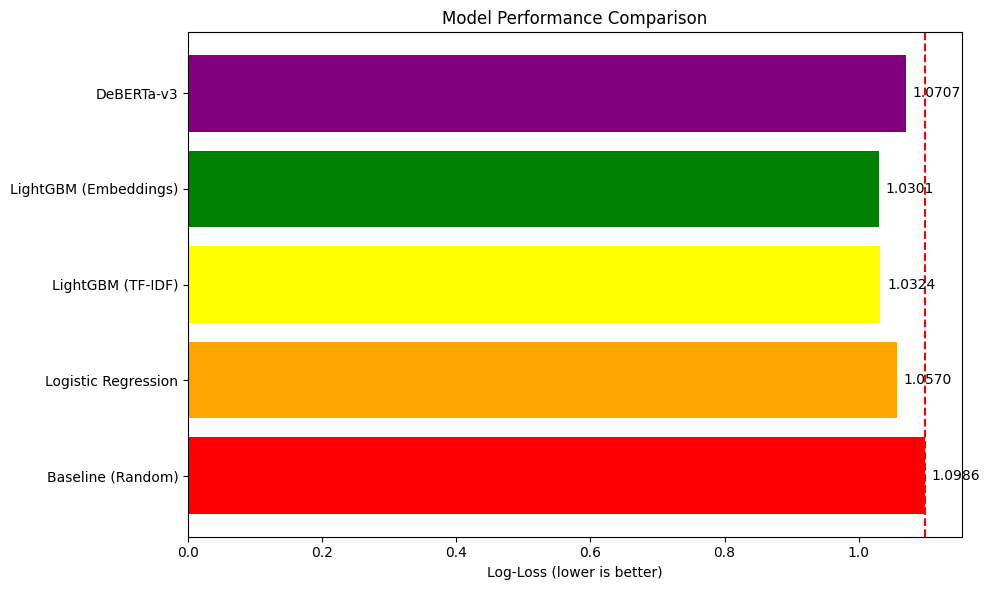

In [28]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Baseline (Random)', 'Logistic Regression', 'LightGBM (TF-IDF)', 'LightGBM (Embeddings)', 'DeBERTa-v3'],
    'Log-Loss': [baseline_logloss, test_logloss, test_logloss_lgb, test_logloss_emb, deberta_logloss],
    'Improvement': ['0%', 
                    f"{((baseline_logloss - test_logloss) / baseline_logloss * 100):.1f}%",
                    f"{((baseline_logloss - test_logloss_lgb) / baseline_logloss * 100):.1f}%",
                    f"{((baseline_logloss - test_logloss_emb) / baseline_logloss * 100):.1f}%",
                   f"{((baseline_logloss - deberta_logloss) / baseline_logloss * 100):.1f}%"]
})

print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = results['Model']
scores = results['Log-Loss']
colors = ['red', 'orange', 'yellow', 'green','purple']

bars = ax.barh(models, scores, color=colors)
ax.set_xlabel('Log-Loss (lower is better)')
ax.set_title('Model Performance Comparison')
ax.axvline(x=baseline_logloss, color='red', linestyle='--', label='Baseline')

for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()

En analitzar globalment els resultats obtinguts pel Log Loss, observem un panorama clarificador respecte al rendiment dels diferents enfocaments. Les solucions basades en Gradient Boosting mitjançant LightGBM es posicionen clarament com a superiors, amb la variant que incorpora embeddings semàntics assolint el millor resultat amb un Log Loss de 1.0301, seguida molt de prop per la versió basada en TF-IDF amb 1.0324. Aquesta supremacia dels models de boosting sobre la resta confirma la seva capacitat per capturar relacions no lineals complexes entre les característiques.

D'altra banda, el model de Deep Learning DeBERTa-v3 obté un rendiment de 1.707, que resulta inferior fins i tot al de la regressió logística amb 1.057. Aquest resultat, inicialment sorprenent donat el poder teòric dels Transformers, ens suggereix una explicació important sobre la naturalesa d'aquest dataset específic. Les característiques estructurals explícites que hem creat mitjançant feature engineering, com ara la longitud de les respostes, la diferència entre aquestes longituds, o l'índex de similitud de Jaccard, posseeixen un pes predictiu immediat i directe. 

En canvi, el DeBERTa ha d'intentar inferir aquests mateixos patrons a partir del text cru, processat exclusivament a través de les seves capes d'atenció. Aquest procés d'aprenentatge de representacions des de zero requereix significativament més dades, més temps d'entrenament o un ajust fi molt més acurat per superar la barrera que representen aquestes heurístiques simples però efectives. És probable que amb un entrenament més prolongat, tècniques d'augmentació de dades o fine-tuning més sofisticat, el DeBERTa podria arribar a competir o superar els models de boosting, però amb els recursos i el temps disponibles per a aquesta pràctica, els models clàssics amb feature engineering demostren ser més eficients.

Confusion Matrix Logistic Regression:
[[1927 1152 1026]
 [1093 1876  937]
 [1031 1020 1481]]

Classification Report:
              precision    recall  f1-score   support

Model A wins       0.48      0.47      0.47      4105
Model B wins       0.46      0.48      0.47      3906
         Tie       0.43      0.42      0.42      3532

    accuracy                           0.46     11543
   macro avg       0.46      0.46      0.46     11543
weighted avg       0.46      0.46      0.46     11543



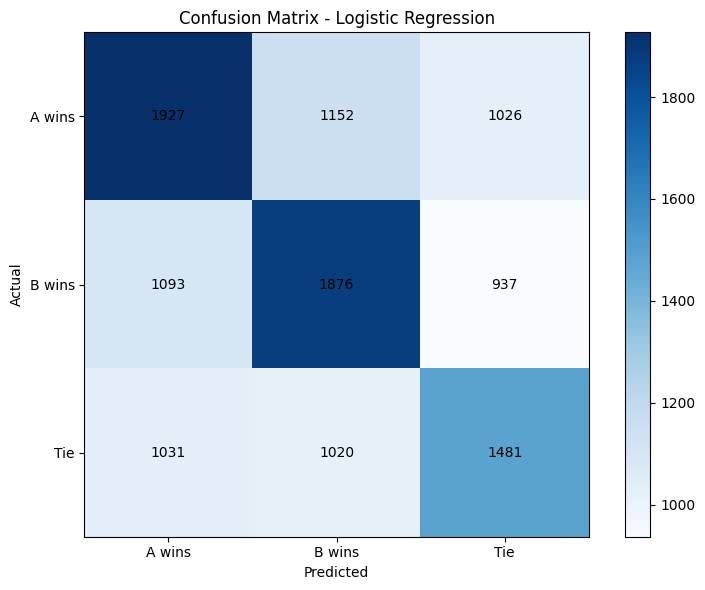

Confusion Matrix LightGBM:
[[2182 1173  750]
 [1165 2015  726]
 [1219 1075 1238]]

Classification Report:
              precision    recall  f1-score   support

Model A wins       0.48      0.53      0.50      4105
Model B wins       0.47      0.52      0.49      3906
         Tie       0.46      0.35      0.40      3532

    accuracy                           0.47     11543
   macro avg       0.47      0.47      0.46     11543
weighted avg       0.47      0.47      0.47     11543



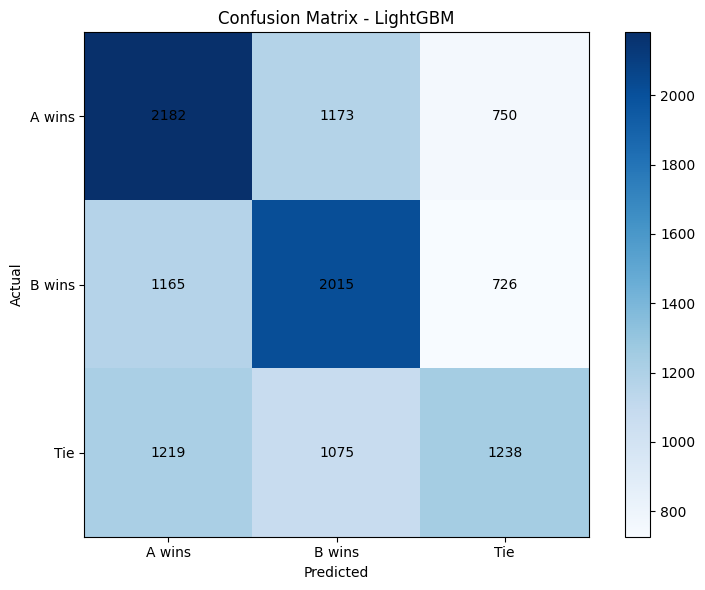

Confusion Matrix LightGBM (Embeddings):
[[2149 1148  808]
 [1116 2024  766]
 [1203 1061 1268]]

Classification Report:
              precision    recall  f1-score   support

Model A wins       0.48      0.52      0.50      4105
Model B wins       0.48      0.52      0.50      3906
         Tie       0.45      0.36      0.40      3532

    accuracy                           0.47     11543
   macro avg       0.47      0.47      0.47     11543
weighted avg       0.47      0.47      0.47     11543



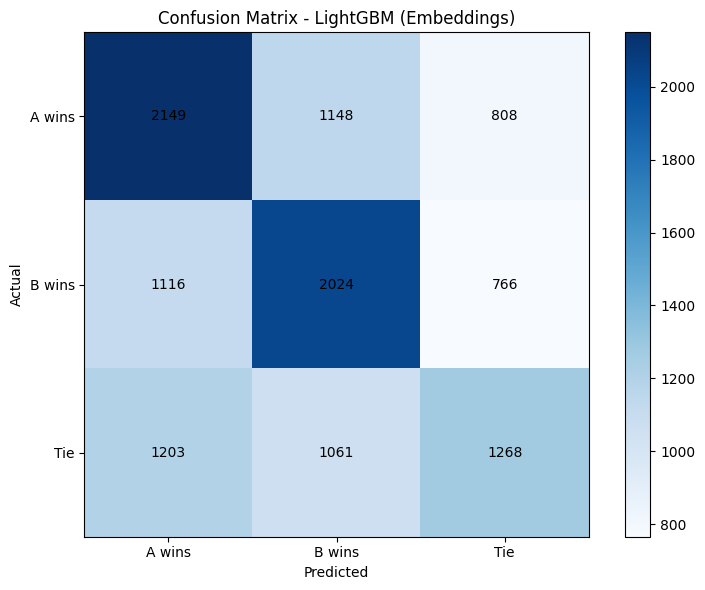

Confusion Matrix DeBERTa:
[[1786 1342  977]
 [1347 1624  935]
 [ 954 1154 1424]]

Classification Report:
              precision    recall  f1-score   support

Model A wins       0.44      0.44      0.44      4105
Model B wins       0.39      0.42      0.40      3906
         Tie       0.43      0.40      0.41      3532

    accuracy                           0.42     11543
   macro avg       0.42      0.42      0.42     11543
weighted avg       0.42      0.42      0.42     11543



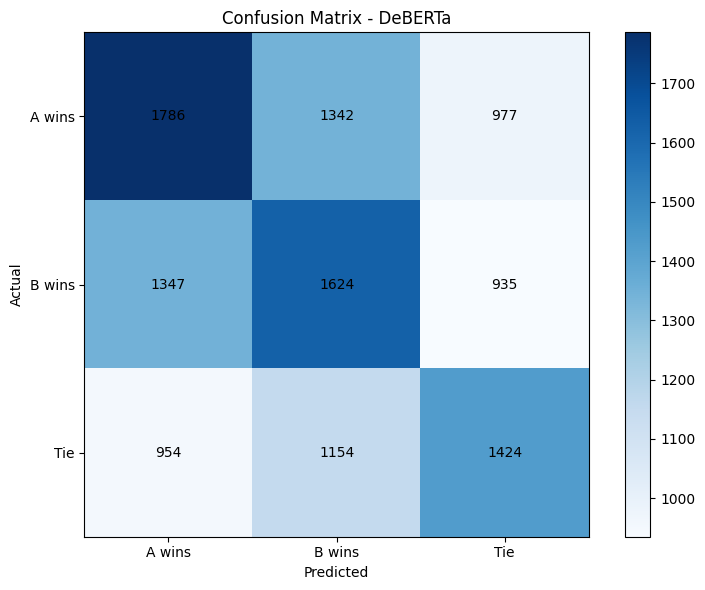

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_lr.predict(X_test_combined)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix Logistic Regression:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Model A wins', 'Model B wins', 'Tie']))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['A wins', 'B wins', 'Tie'])
ax.set_yticklabels(['A wins', 'B wins', 'Tie'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Logistic Regression')

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

y_pred = clf_lgb.predict(X_test_lgb)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix LightGBM:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Model A wins', 'Model B wins', 'Tie']))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['A wins', 'B wins', 'Tie'])
ax.set_yticklabels(['A wins', 'B wins', 'Tie'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - LightGBM')

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

y_pred = clf_lgb_embeddings.predict(X_test_embeddings)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix LightGBM (Embeddings):")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Model A wins', 'Model B wins', 'Tie']))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['A wins', 'B wins', 'Tie'])
ax.set_yticklabels(['A wins', 'B wins', 'Tie'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - LightGBM (Embeddings)')

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test_deberta, y_pred_deberta)
print("Confusion Matrix DeBERTa:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_deberta, y_pred_deberta, target_names=['Model A wins', 'Model B wins', 'Tie']))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['A wins', 'B wins', 'Tie'])
ax.set_yticklabels(['A wins', 'B wins', 'Tie'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - DeBERTa')

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

En analitzar les matrius de confusió obtingudes, els models LightGBM, tant en la seva versió amb TF-IDF com amb embeddings, es consoliden com els més robustos i equilibrats, assolint una precisió global (accuracy) del 47%. Si observem en detall la matriu del LightGBM, identifiquem una diagonal principal sòlida amb 2182 i 2149 encerts per a la classe "Model A guanya" i 2015 i 2024 per a la classe "Model B guanya" respectivament. Això indica que el model ha capturat eficaçment les regles heurístiques subjacents, probablement relacionades amb la longitud i el format de les respostes, que tendeixen a determinar un guanyador clar en la majoria de casos.

L'informe de classificació reforça aquesta interpretació mostrant un equilibri gairebé simètric entre les classes "A guanya" i "B guanya", amb valors de precisió i recall molt similars (al voltant del 0.48 i 0.52 respectivament). Aquest comportament equilibrat demostra que el model no presenta biaixos sistemàtics cap a cap de les dues posicions, tractant-les de manera equitativa independentment de si la resposta superior prové del model A o del model B.

No obstant això, el punt feble del LightGBM es manifesta clarament en la detecció de la classe "Empat". Tot i que aconsegueix identificar correctament 1268/1238 empats, confon un nombre considerable d'empats reals amb victòries aparents, classificant erròniament 1203/1219 com a victòries del model A i 1075/1061 com a victòries del model B. El recall de només 0.36/0.35 per a aquesta classe revela que les característiques estructurals, per molt informatives que siguin per distingir guanyadors clars, resulten insuficients per capturar la subtilesa inherent d'un empat, on dues respostes diferents poden ser igualment vàlides o acceptables. El model, entrenat sobre característiques que emfatitzen diferències, tendeix a "forçar" una decisió de victòria fins i tot quan les respostes són efectivament equivalents.

La regressió logística, malgrat ser un model lineal conceptualment més simple, presenta un comportament força correcte amb un accuracy del 46%, molt proper al del LightGBM. Resulta especialment interessant que mentre el LightGBM obté un recall de 0.36/0.35 en empats, la regressió logística aconsegueix pujar a 0.42, havent classificat correctament 1481 empats en comparació amb els 1268/1238 del LightGBM. Aquest fenomen es pot explicar pel fet que la regressió logística, al ser un model menys complex i estar regularitzat, resulta "menys agressiva" en la recerca de característiques distintives de victòria. Davant del dubte o del soroll en els patrons, tendeix a adoptar una posició més conservadora, cosa que paradoxalment l'ajuda a identificar millor aquells casos on realment no hi ha un guanyador clar. Els models de Boosting, en canvi, amb la seva capacitat d'ajustar arbres profunds, poden intentar trobar patrons de victòria fins i tot on no n'existeixen de genuïns.

Finalment, el model DeBERTa presenta sorprenentment un rendiment inferior als models anteriors. La seva matriu de confusió revela dificultats substancials per discriminar quina resposta és genuïnament superior, mostrant una confusió elevada entre les classes A i B. Això suggereix que, en aquesta fase de l'entrenament amb els recursos computacionals disponibles, el model encara no ha aconseguit internalitzar els criteris implícits que determinen per què una resposta és millor que una altra. Respecte als empats, observem que el model n'identifica més que el LightGBM. Atribuïm aquest comportament al fet que, en no trobar patrons clars i consistents de victòria durant el seu procés d'aprenentatge, el model tendeix a no decantar-se, assignant més mostres a la categoria d'empat per manca de confiança suficient en qualsevol de les opcions guanyadores. 

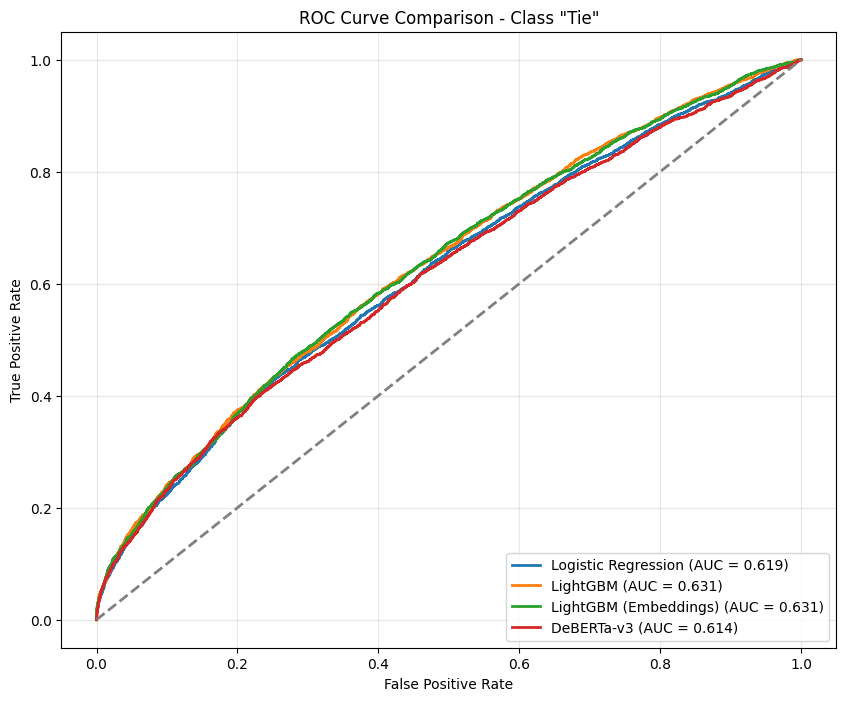

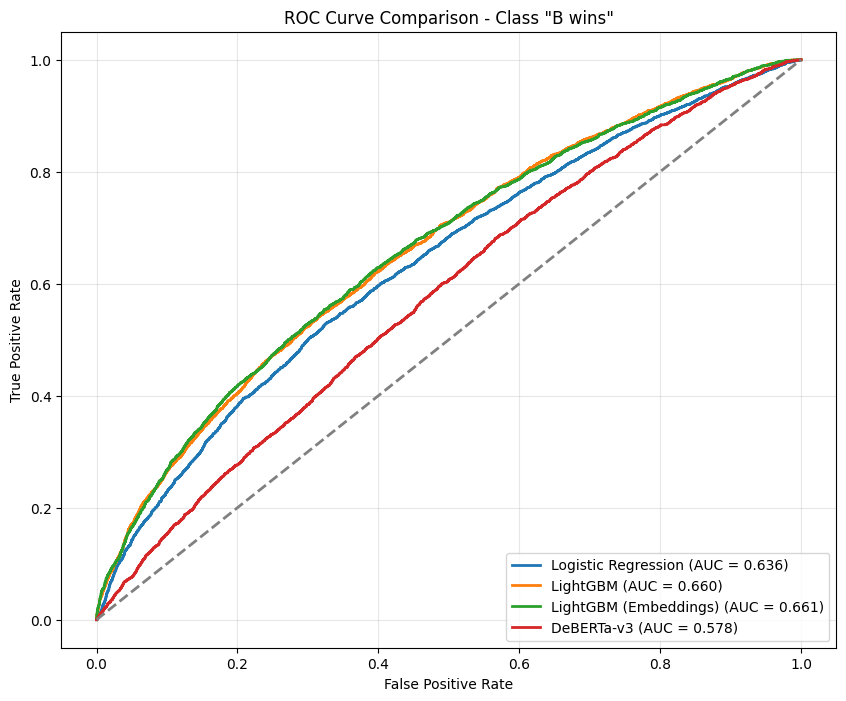

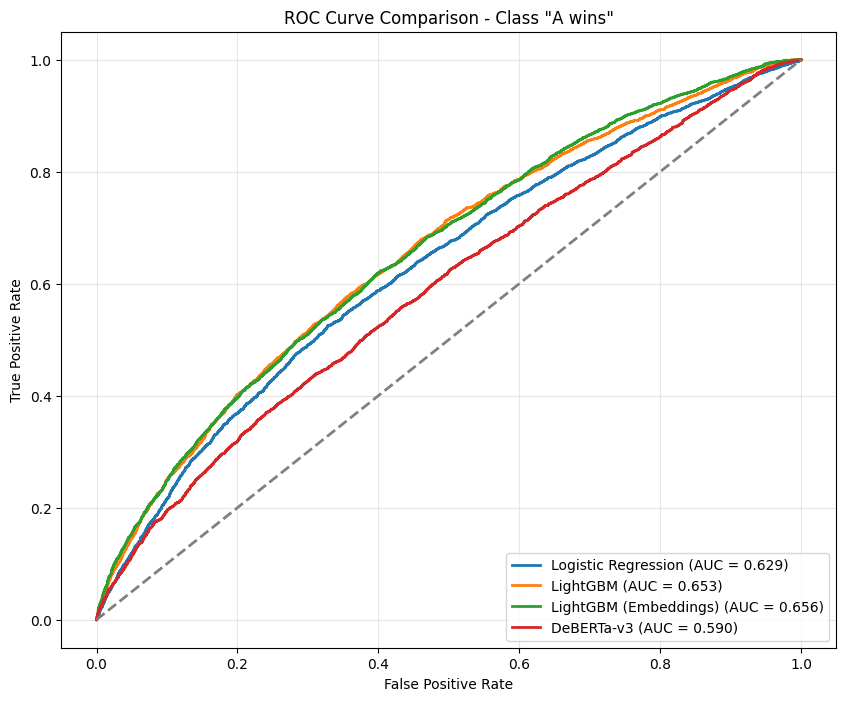

In [30]:
# ROC Curves for all models - Class "Tie" (2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])[:, 2] 

models = {
    'Logistic Regression': y_pred_proba[:, 2],
    'LightGBM': y_pred_proba_lgb[:, 2],
    'LightGBM (Embeddings)': y_pred_proba_emb[:, 2],
    'DeBERTa-v3': y_probs[:, 2] 
}

plt.figure(figsize=(10, 8))

for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='grey') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Class "Tie"')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# ROC Curves for all models - Class "B wins" (1)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])[:, 1] 

models = {
    'Logistic Regression': y_pred_proba[:, 1],
    'LightGBM': y_pred_proba_lgb[:, 1],
    'LightGBM (Embeddings)': y_pred_proba_emb[:, 1],
    'DeBERTa-v3': y_probs[:, 1] 
}

plt.figure(figsize=(10, 8))

for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='grey') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Class "B wins"')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# ROC Curves for all models - Class "A wins" (0)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])[:, 0] 

models = {
    'Logistic Regression': y_pred_proba[:, 0],
    'LightGBM': y_pred_proba_lgb[:, 0],
    'LightGBM (Embeddings)': y_pred_proba_emb[:, 0],
    'DeBERTa-v3': y_probs[:, 0] 
}

plt.figure(figsize=(10, 8))

for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Class "A wins"')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


En examinar les corbes ROC generades per a cadascuna de les tres classes, obtenim una perspectiva complementària sobre la capacitat discriminativa dels nostres models a través de tots els possibles llindars de decisió. Els resultats revelen diversos patrons significatius que mereixen una discussió detallada.

Per a la classe "Empat", que hem identificat com la més problemàtica en l'anàlisi de les matrius de confusió, les corbes ROC confirmen les dificultats inherents a aquesta tasca. Cap model aconsegueix distanciar-se significativament dels altres, i tots presenten valors d'AUC relativament modestos. Això reflecteix la natura fonamentalment ambigua dels empats en aquest context: sovint no existeixen característiques objectives i mesurables que distingeixin clarament un empat genuí d'una victòria ajustada. Els avaluadors humans que van etiquetar les dades originals probablement van aplicar criteris subjectius i variables, cosa que dificulta que qualsevol model aprengui un patró consistent i generalitzable.

En canvi, per a les classes "Model A guanya" i "Model B guanya", començem a observar una separació més nítida en el rendiment dels diferents enfocaments. Els models LightGBM, tant el basat en TF-IDF com especialment el que incorpora embeddings, aconsegueixen distanciar-se lleument de la regressió logística, exhibint corbes més elevades i valors d'AUC superiors. Això confirma que aquests models han après efectivament a identificar els factors que determinen una victòria clara, aprofitant sobretot les característiques estructurals (longitud, format) . En quant a deBERTa, degut als factors limitants a l'entrenament i la dificultat que troba alhora de distingir quina es la millor resposta es queda enrere de la resta.

El fet que els resultats puguin considerar-se relativament modestos en termes absoluts es degut a que aquesta tasca implica replicar judicis humans sobre preferències entre respostes, una àrea on existeix una considerable subjectivitat inherent. El que una persona pot considerar la "millor" resposta pot dependre de factors contextuals, preferències personals sobre l'estil comunicatiu, o fins i tot l'estat d'ànim de l'avaluador en aquell moment. Encara que certes preferències sistemàtiques existeixen (com la tendència a valorar respostes més llargues que semblen més completes), no sempre expliquen completament per què una resposta específica es considera superior a una altra.

Donada aquesta naturalesa inherentment sorollosa i subjectiva de la classificació, considerem que els nostres resultats són suficientment bons i reflecteixen una comprensió genuïna dels patrons detectables en les dades. 

## Conclusions finals

Aquest projecte ha explorat diversos enfocaments per construir un sistema automàtic capaç de predir les preferències humanes entre respostes generades per diferents models de llenguatge. Hem recorregut un camí que va des de models lineals simples fins a arquitectures de Deep Learning d'última generació, descobrint en el procés lliçons importants sobre quan i per què cada tipus d'aproximació resulta més adequada.

El primer aprenentatge fonamental és que la qualitat del feature engineering pot ser tant o més important que la sofisticació de l'algorisme utilitzat. Les característiques estructurals que vam dissenyar, com les diferències de longitud, els índexs de similitud o el comptatge d'elements formals, van capturar patrons altament predictius de les preferències humanes. Els models basats en LightGBM van poder explotar directament aquestes característiques per construir regles de decisió efectives, aconseguint els millors resultats del nostre estudi.

En segon lloc, hem observat que la incorporació d'embeddings semàntics proporciona millores petites però consistents sobre les representacions purament lèxiques com el TF-IDF. Això suggereix que, més enllà de les característiques superficials, existeixen aspectes semàntics profunds que influeixen en la percepció de qualitat, tot i que el seu impacte sigui més subtil que el de factors com la longitud o el format.

Finalment, els resultats del DeBERTa ens recorden que els models de Deep Learning, malgrat el seu immens potencial, requereixen recursos substancials (dades, computació, temps) per superar enfocaments més tradicionals ben executats. En contextos amb recursos limitats o quan les característiques rellevants poden ser explícitament enginyerades, els mètodes clàssics continuen sent competitius i sovint preferibles per la seva eficiència i interpretabilitat.

Aquest treball demostra que la construcció de sistemes efectius de Machine Learning requereix un equilibri cuidadós entre la comprensió del domini, el disseny intel·ligent de característiques i la selecció d'algorismes apropiats per al problema i els recursos disponibles.